# Deep Learning with Torch - Tutorial 3

## Convolutional networks
![LeNet](http://fastml.com/images/cifar/lenet5.png)

### Let's take a look at a simple convolutional layer

In [1]:
require 'nn'
conv = nn.SpatialConvolution(3, 16, 5, 5, 4, 4, 0, 0) 
-- 3 input maps, 16 output maps
-- 5x5 kernels, stride 4x4, padding 0x0

print(conv)

nn.SpatialConvolution(3 -> 16, 5x5, 4,4)
{
  dH : 4
  dW : 4
  nInputPlane : 3
  output : DoubleTensor - empty
  kH : 5
  gradBias : DoubleTensor - size: 16
  padH : 0
  bias : DoubleTensor - size: 16
  weight : DoubleTensor - size: 16x3x5x5
  _type : torch.DoubleTensor
  gradWeight : DoubleTensor - size: 16x3x5x5
  padW : 0
  nOutputPlane : 16
  kW : 5
  gradInput : DoubleTensor - empty
}


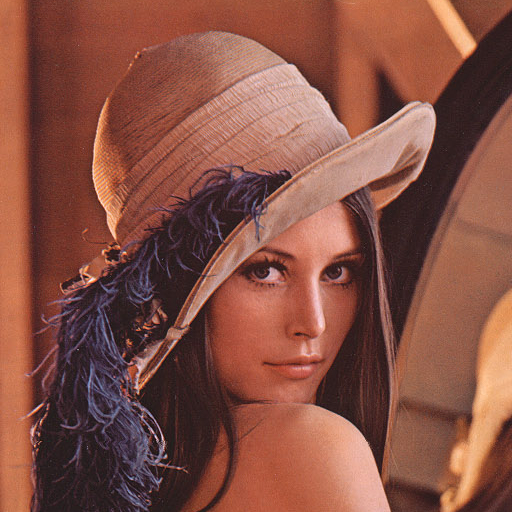

In [2]:
require 'image'
img = image.lena()
itorch.image(img)

In [3]:
output = conv:forward(img)
print(output:size())

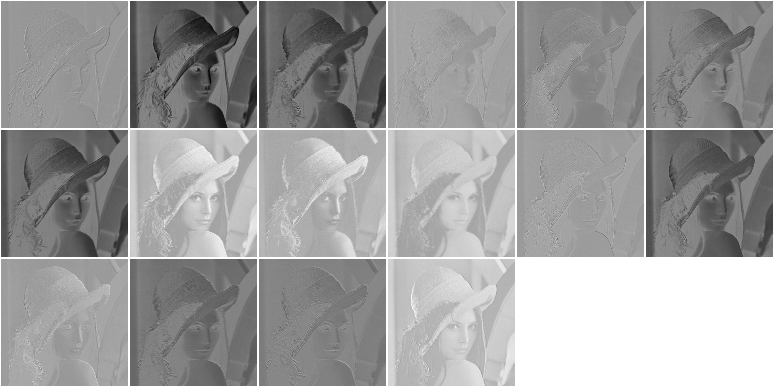

In [4]:
itorch.image(output)

   3
 255
 255
[torch.LongStorage of size 3]



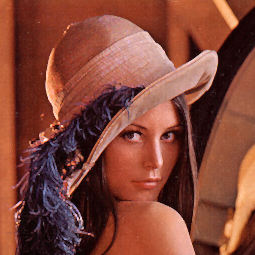

In [5]:
pool = nn.SpatialMaxPooling(3,3,2,2)
outPooled = pool:forward(img)
print(outPooled:size())
itorch.image(outPooled)

# Full Example - Training a ConvNet on Cifar10

__We have 5 steps left to do in training our first torch neural network__
1. Load and normalize data
2. Define Neural Network
3. Define Loss function
4. Train network on training data
5. Test network on test data.


## 1. Load and normalize data
Generally, when you have to deal with image, text, audio or video data, you can use standard functions like: [__image.load__](https://github.com/torch/image#res-imageloadfilename-depth-tensortype) or [__audio.load__](https://github.com/soumith/lua---audio#usage) to load your data into a _torch.Tensor_ or a Lua table, as convenient.

We shall use the CIFAR-10 dataset, which has the classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.  
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.
![CIFAR-10 image](https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png)

The dataset has 50,000 training images and 10,000 test images in total.



Today, in the interest of time, we prepared the data before-hand into a 4D torch ByteTensor of size 50000x3x32x32 (training) and 10000x3x32x32 (testing)
Let us load the data and inspect it.

In [6]:
trainset = torch.load('/home/ehoffer/Datasets/Cifar10/cifar10-train.t7')
testset = torch.load('/home/ehoffer/Datasets/Cifar10/cifar10-test.t7')

classes = {'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

function shuffle(data,ydata) --shuffle data function
    local RandOrder = torch.randperm(data:size(1)):long()
    return data:index(1,RandOrder), ydata:index(1,RandOrder)
end

trainData = trainset.data:float() -- convert the data from a ByteTensor to a float Tensor.
trainLabels = trainset.label:float():add(1)

testData = testset.data:float()
testLabels = testset.label:float():add(1)

In [7]:
print(trainset)

For fun, let us display an image:

{
  data : ByteTensor - size: 50000x3x32x32
  label : ByteTensor - size: 50000
}


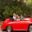

automobile	


In [8]:
itorch.image(trainData[100]) -- display the 100-th image in dataset
print(classes[trainLabels[100]])

__One of the most important things you can do in conditioning your data (in general in data-science or machine learning) is to make your data to have a mean of 0.0 and standard-deviation of 1.0.__

Let us do that as a final step of our data processing.

To do this, we introduce you to the tensor indexing operator.
It is shown by example:

In [9]:
redChannel = trainData[{ {}, {1}, {}, {}  }] -- this picks {all images, 1st channel, all vertical pixels, all horizontal pixels}

In [10]:
print(#redChannel)

Moving back to mean-subtraction and standard-deviation based scaling, doing this operation is simple, using the indexing operator that we learnt above:

In [11]:
mean = {} -- store the mean, to normalize the test set in the future
stdv  = {} -- store the standard-deviation for the future
for i=1,3 do -- over each image channel
    mean[i] = trainData[{ {}, {i}, {}, {}  }]:mean() -- mean estimation
    print('Channel ' .. i .. ', Mean: ' .. mean[i])
    trainData[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction
    
    stdv[i] = trainData[{ {}, {i}, {}, {}  }]:std() -- std estimation
    print('Channel ' .. i .. ', Standard Deviation: ' .. stdv[i])
    trainData[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

-- Normalize test set using same values

for i=1,3 do -- over each image channel
    testData[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction    
    testData[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

Channel 1, Mean: 125.30691804687	


Channel 1, Standard Deviation: 62.993219892912	


Channel 2, Mean: 122.95039414062	


Channel 2, Standard Deviation: 62.088708246722	


Channel 3, Mean: 113.86538318359	


Channel 3, Standard Deviation: 66.704900292063	


As you notice, our data is now normalized and ready to be used.

## 2. Time to define our neural network


### Using alternative implementation - CUDNN
By using the torch cudnn package, we can speed up our computations.


In [12]:
require 'nn'
require 'cunn'
require 'cudnn'

model = nn.Sequential()
model:add(cudnn.SpatialConvolution(3, 32, 5, 5)) -- 3 input image channel, 32 output channels, 5x5 convolution kernel
model:add(cudnn.SpatialMaxPooling(2,2,2,2))      -- A max-pooling operation that looks at 2x2 windows and finds the max.
model:add(cudnn.ReLU(true))                          -- ReLU activation function
model:add(nn.SpatialBatchNormalization(32))    --Batch normalization will provide quicker convergence
model:add(cudnn.SpatialConvolution(32, 64, 3, 3))
model:add(cudnn.SpatialMaxPooling(2,2,2,2))
model:add(cudnn.ReLU(true))
model:add(nn.SpatialBatchNormalization(64))
model:add(cudnn.SpatialConvolution(64, 32, 3, 3))
model:add(nn.View(32*4*4):setNumInputDims(3))  -- reshapes from a 3D tensor of 32x4x4 into 1D tensor of 32*4*4
model:add(nn.Linear(32*4*4, 256))             -- fully connected layer (matrix multiplication between input and weights)
model:add(cudnn.ReLU(true))
model:add(nn.Dropout(0.5))                      --Dropout layer with p=0.5
model:add(nn.Linear(256, #classes))            -- 10 is the number of outputs of the network (in this case, 10 digits)
model:add(nn.LogSoftMax())                     -- converts the output to a log-probability. Useful for classificati

model:cuda()
criterion = nn.ClassNLLCriterion():cuda()


w, dE_dw = model:getParameters()
print('Number of parameters:', w:nElement()) 

Number of parameters:	173482	


## Training the network
We can now train the network efficiently. We'll do 25 epochs over all training data, shuffling the samples every epoch.

In [13]:
require 'optim'

batchSize = 128
optimState = {}


function forwardNet(data,labels, train)
    --another helpful function of optim is ConfusionMatrix
    local confusion = optim.ConfusionMatrix(classes)
    local lossAcc = 0
    local numBatches = 0
    if train then
        --set network into training mode
        model:training()
    else
        model:evaluate()
    end
    for i = 1, data:size(1) - batchSize, batchSize do
        numBatches = numBatches + 1
        local x = data:narrow(1, i, batchSize):cuda()
        local yt = labels:narrow(1, i, batchSize):cuda()
        local y = model:forward(x)
        local err = criterion:forward(y, yt)
        lossAcc = lossAcc + err
        confusion:batchAdd(y,yt)
        
        if train then
            function feval()
                model:zeroGradParameters() --zero grads
                local dE_dy = criterion:backward(y,yt)
                model:backward(x, dE_dy) -- backpropagation
            
                return err, dE_dw
            end
        
            optim.adam(feval, w, optimState)
        end
    end
    
    confusion:updateValids()
    local avgLoss = lossAcc / numBatches
    local avgError = 1 - confusion.totalValid
    
    return avgLoss, avgError, tostring(confusion)
end

function plotError(trainError, testError, title)
    local range = torch.range(1, trainError:size(1))
    local plot = itorch.Plot()
    plot:line(range, trainError * 100, 'red', 'Training error')
    plot:line(range, testError * 100, 'blue', 'Test error'):draw()
    plot:title(title):redraw()
    plot:xaxis('epoch'):yaxis('% error'):redraw()
    plot:legend(true)
    plot:redraw()
end

---------------------------------------------------------------------

epochs = 25
trainLoss = torch.Tensor(epochs)
testLoss = torch.Tensor(epochs)
trainError = torch.Tensor(epochs)
testError = torch.Tensor(epochs)

--reset net weights
model:apply(function(l) l:reset() end)

for e = 1, epochs do
    trainData, trainLabels = shuffle(trainData, trainLabels) --shuffle training data
    trainLoss[e], trainError[e] = forwardNet(trainData, trainLabels, true)
    testLoss[e], testError[e], confusion = forwardNet(testData, testLabels, false)
    
    if e % 5 == 0 then
        print('Epoch ' .. e .. ':')
        print('Training error: ' .. trainError[e], 'Training Loss: ' .. trainLoss[e])
        print('Test error: ' .. testError[e], 'Test Loss: ' .. testLoss[e])
        print(confusion)
    end
end

plotError(trainError, testError, 'Classification Error')

Epoch 5:	
Training error: 0.27161458333333	Training Loss: 0.76846499389563	
Test error: 0.28635817307692	Test Loss: 0.83465454517267	
ConfusionMatrix:
[[     782      26      43      17      21      10       5      14      41      39]   78.357% 	[class: airplane]
 [      17     797       8      14       4       6       8       4      12     129]   79.780% 	[class: automobile]
 [      77       7     522      65     115      69      61      55      11      17]   52.252% 	[class: bird]
 [      28       9      56     536      81     145      48      55      10      29]   53.761% 	[class: cat]
 [      20       4      33      57     711      23      36     101       9       6]   71.100% 	[class: deer]
 [      18       7      37     189      68     578      22      65       8       5]   57.974% 	[class: dog]
 [       5      10      36      89      58      38     747       8       6       3]   74.700% 	[class: frog]
 [      20       4      28      23      64      45       8     792       2    

Epoch 10:	
Training error: 0.20606971153846	Training Loss: 0.58643079270155	
Test error: 0.25590945512821	Test Loss: 0.76657770497677	
ConfusionMatrix:
[[     739      19      67      21      25      10       7       8      72      30]   74.048% 	[class: airplane]
 [      14     867       7      16       1       8      12       3      26      45]   86.787% 	[class: automobile]
 [      50       3     671      44      56      59      61      35      13       7]   67.167% 	[class: bird]
 [      16       5      88     512      59     200      61      33      12      11]   51.354% 	[class: cat]
 [      17       0     109      46     672      37      50      58       8       3]   67.200% 	[class: deer]
 [      11       2      62     135      32     688      13      48       5       1]   69.007% 	[class: dog]
 [       3       1      53      62      18      20     832       5       5       1]   83.200% 	[class: frog]
 [      13       1      39      25      50      63       7     791       1   

Epoch 15:	
Training error: 0.1697516025641	Training Loss: 0.47662585614583	
Test error: 0.25440705128205	Test Loss: 0.81090595668707	
ConfusionMatrix:
[[     770      14      57      16      10       6       4      14      78      29]   77.154% 	[class: airplane]
 [      20     847       6      10       0       3       4       2      37      70]   84.785% 	[class: automobile]
 [      60       3     679      40      54      45      54      27      24      13]   67.968% 	[class: bird]
 [      20      14      92     497      58     185      53      35      26      17]   49.850% 	[class: cat]
 [      23       3      97      40     685      38      29      56      26       3]   68.500% 	[class: deer]
 [      14       6      67     113      44     667      17      51       8      10]   66.901% 	[class: dog]
 [       6       4      64      48      45      19     791       4      13       6]   79.100% 	[class: frog]
 [      17       3      42      22      40      52       5     804       3    

Epoch 20:	
Training error: 0.14641426282051	Training Loss: 0.40428276421168	
Test error: 0.24178685897436	Test Loss: 0.78964339616971	
ConfusionMatrix:
[[     798      14      43      11      26       7      15       9      39      36]   79.960% 	[class: airplane]
 [      19     845       6      13       0       5       5       1      26      79]   84.585% 	[class: automobile]
 [      65       3     645      52      76      44      58      34      15       7]   64.565% 	[class: bird]
 [      24       7      63     582      65     148      57      30       9      12]   58.375% 	[class: cat]
 [      10       0      50      54     755      41      29      53       6       2]   75.500% 	[class: deer]
 [      11       3      42     168      44     659      21      43       2       4]   66.098% 	[class: dog]
 [       3       2      46      54      47      25     809       6       4       4]   80.900% 	[class: frog]
 [      13       0      33      30      52      54       4     803       2   

Epoch 25:	
Training error: 0.12642227564103	Training Loss: 0.35004375389753	
Test error: 0.24799679487179	Test Loss: 0.84848485619594	
ConfusionMatrix:
[[     813      21      42      20      17       7       5       9      27      37]   81.463% 	[class: airplane]
 [      18     859       5       4       1       4       6       4      15      83]   85.986% 	[class: automobile]
 [      72       6     593      61      96      59      53      32      12      15]   59.359% 	[class: bird]
 [      32      10      54     591      56     140      58      32       9      15]   59.278% 	[class: cat]
 [      19       0      47      65     761      33      27      39       4       5]   76.100% 	[class: deer]
 [      20       5      35     169      42     653      21      44       1       7]   65.496% 	[class: dog]
 [       6       3      40      62      65      26     787       4       2       5]   78.700% 	[class: frog]
 [      17       2      26      34      48      46       6     807       1   

Okay, first step. Let us display an image from the test set to get familiar.

automobile	


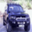

In [14]:
model:evaluate()   --turn off dropout

print(classes[testLabels[10]])
itorch.image(testData[10])
predicted = model:forward(testData[10]:view(1,3,32,32):cuda())

In [15]:
-- the output of the network is Log-Probabilities. To convert them to probabilities, you have to take e^x 
print(predicted:exp())

You can see the network predictions. The network assigned a probability to each classes, given the image.

To make it clearer, let us tag each probability with it's class-name:

In [16]:
for i=1,predicted:size(2) do
    print(classes[i],predicted[1][i])
end
preds= predicted[1]:float()
plot = itorch.Plot()

line = torch.linspace(0,9,10)
plot:quad(line,torch.zeros(#classes),line+1,preds,'red',classes):xaxis('class #'):yaxis("Prob(class)"):title('Classification'):draw()

Columns 1 to 6
 3.9319e-04  5.1223e-01  3.5335e-06  1.2572e-07  1.7273e-09  2.3654e-10

Columns 7 to 10
 7.2769e-08  3.8928e-10  3.8841e-03  4.8349e-01
[torch.CudaTensor of size 1x10]


airplane	0.00039319021743722	
automobile	0.5122275352478	
bird	3.5335403936188e-06	
cat	1.2571697993735e-07	
deer	1.727276988106e-09	
dog	2.3654228575865e-10	
frog	7.2769260839323e-08	
horse	3.8927885914752e-10	
ship	0.003884110134095	
truck	0.48349162936211	


## Visualizing Network Weights+Activations
We can reach every value at each layer (output,weight,gradients) and visualize them.

We get a layer and values using:

In [17]:
layer6 = model:get(6)

layer6_weights = layer6.weights -- Getting the weights
layer6_output = layer6.output -- Getting the output

So visualizing the 1st layer weights is as simple as (scaling up so we can see anything):

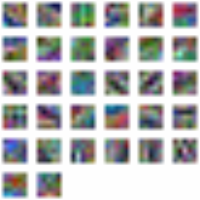

In [18]:
Weights_1st_Layer = model:get(1).weight
scaledWeights = image.scale(image.toDisplayTensor({input=Weights_1st_Layer,padding=2}),200)
itorch.image(scaledWeights)

And to visualize network activation, we will feed another sample and examine the output of each layer

Input Image	


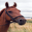

Layer 	1	cudnn.SpatialConvolution(3 -> 32, 5x5)	


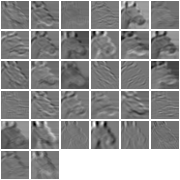

Layer 	2	cudnn.SpatialMaxPooling(2x2, 2,2)	


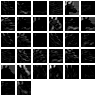

Layer 	3	cudnn.ReLU	


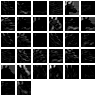

Layer 	4	nn.SpatialBatchNormalization	


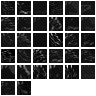

Layer 	5	cudnn.SpatialConvolution(32 -> 64, 3x3)	


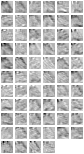

Layer 	6	cudnn.SpatialMaxPooling(2x2, 2,2)	


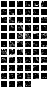

Layer 	7	cudnn.ReLU	


Layer 	8	nn.SpatialBatchNormalization	


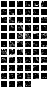

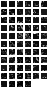

Layer 	9	cudnn.SpatialConvolution(64 -> 32, 3x3)	


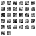

In [19]:
print('Input Image')
itorch.image(testData[100])
model:forward(testData[100]:view(1,3,32,32):cuda())
for l=1,9 do
  print('Layer ' ,l, tostring(model:get(l)))
  layer_output = model:get(l).output[1]
  itorch.image(layer_output)
end

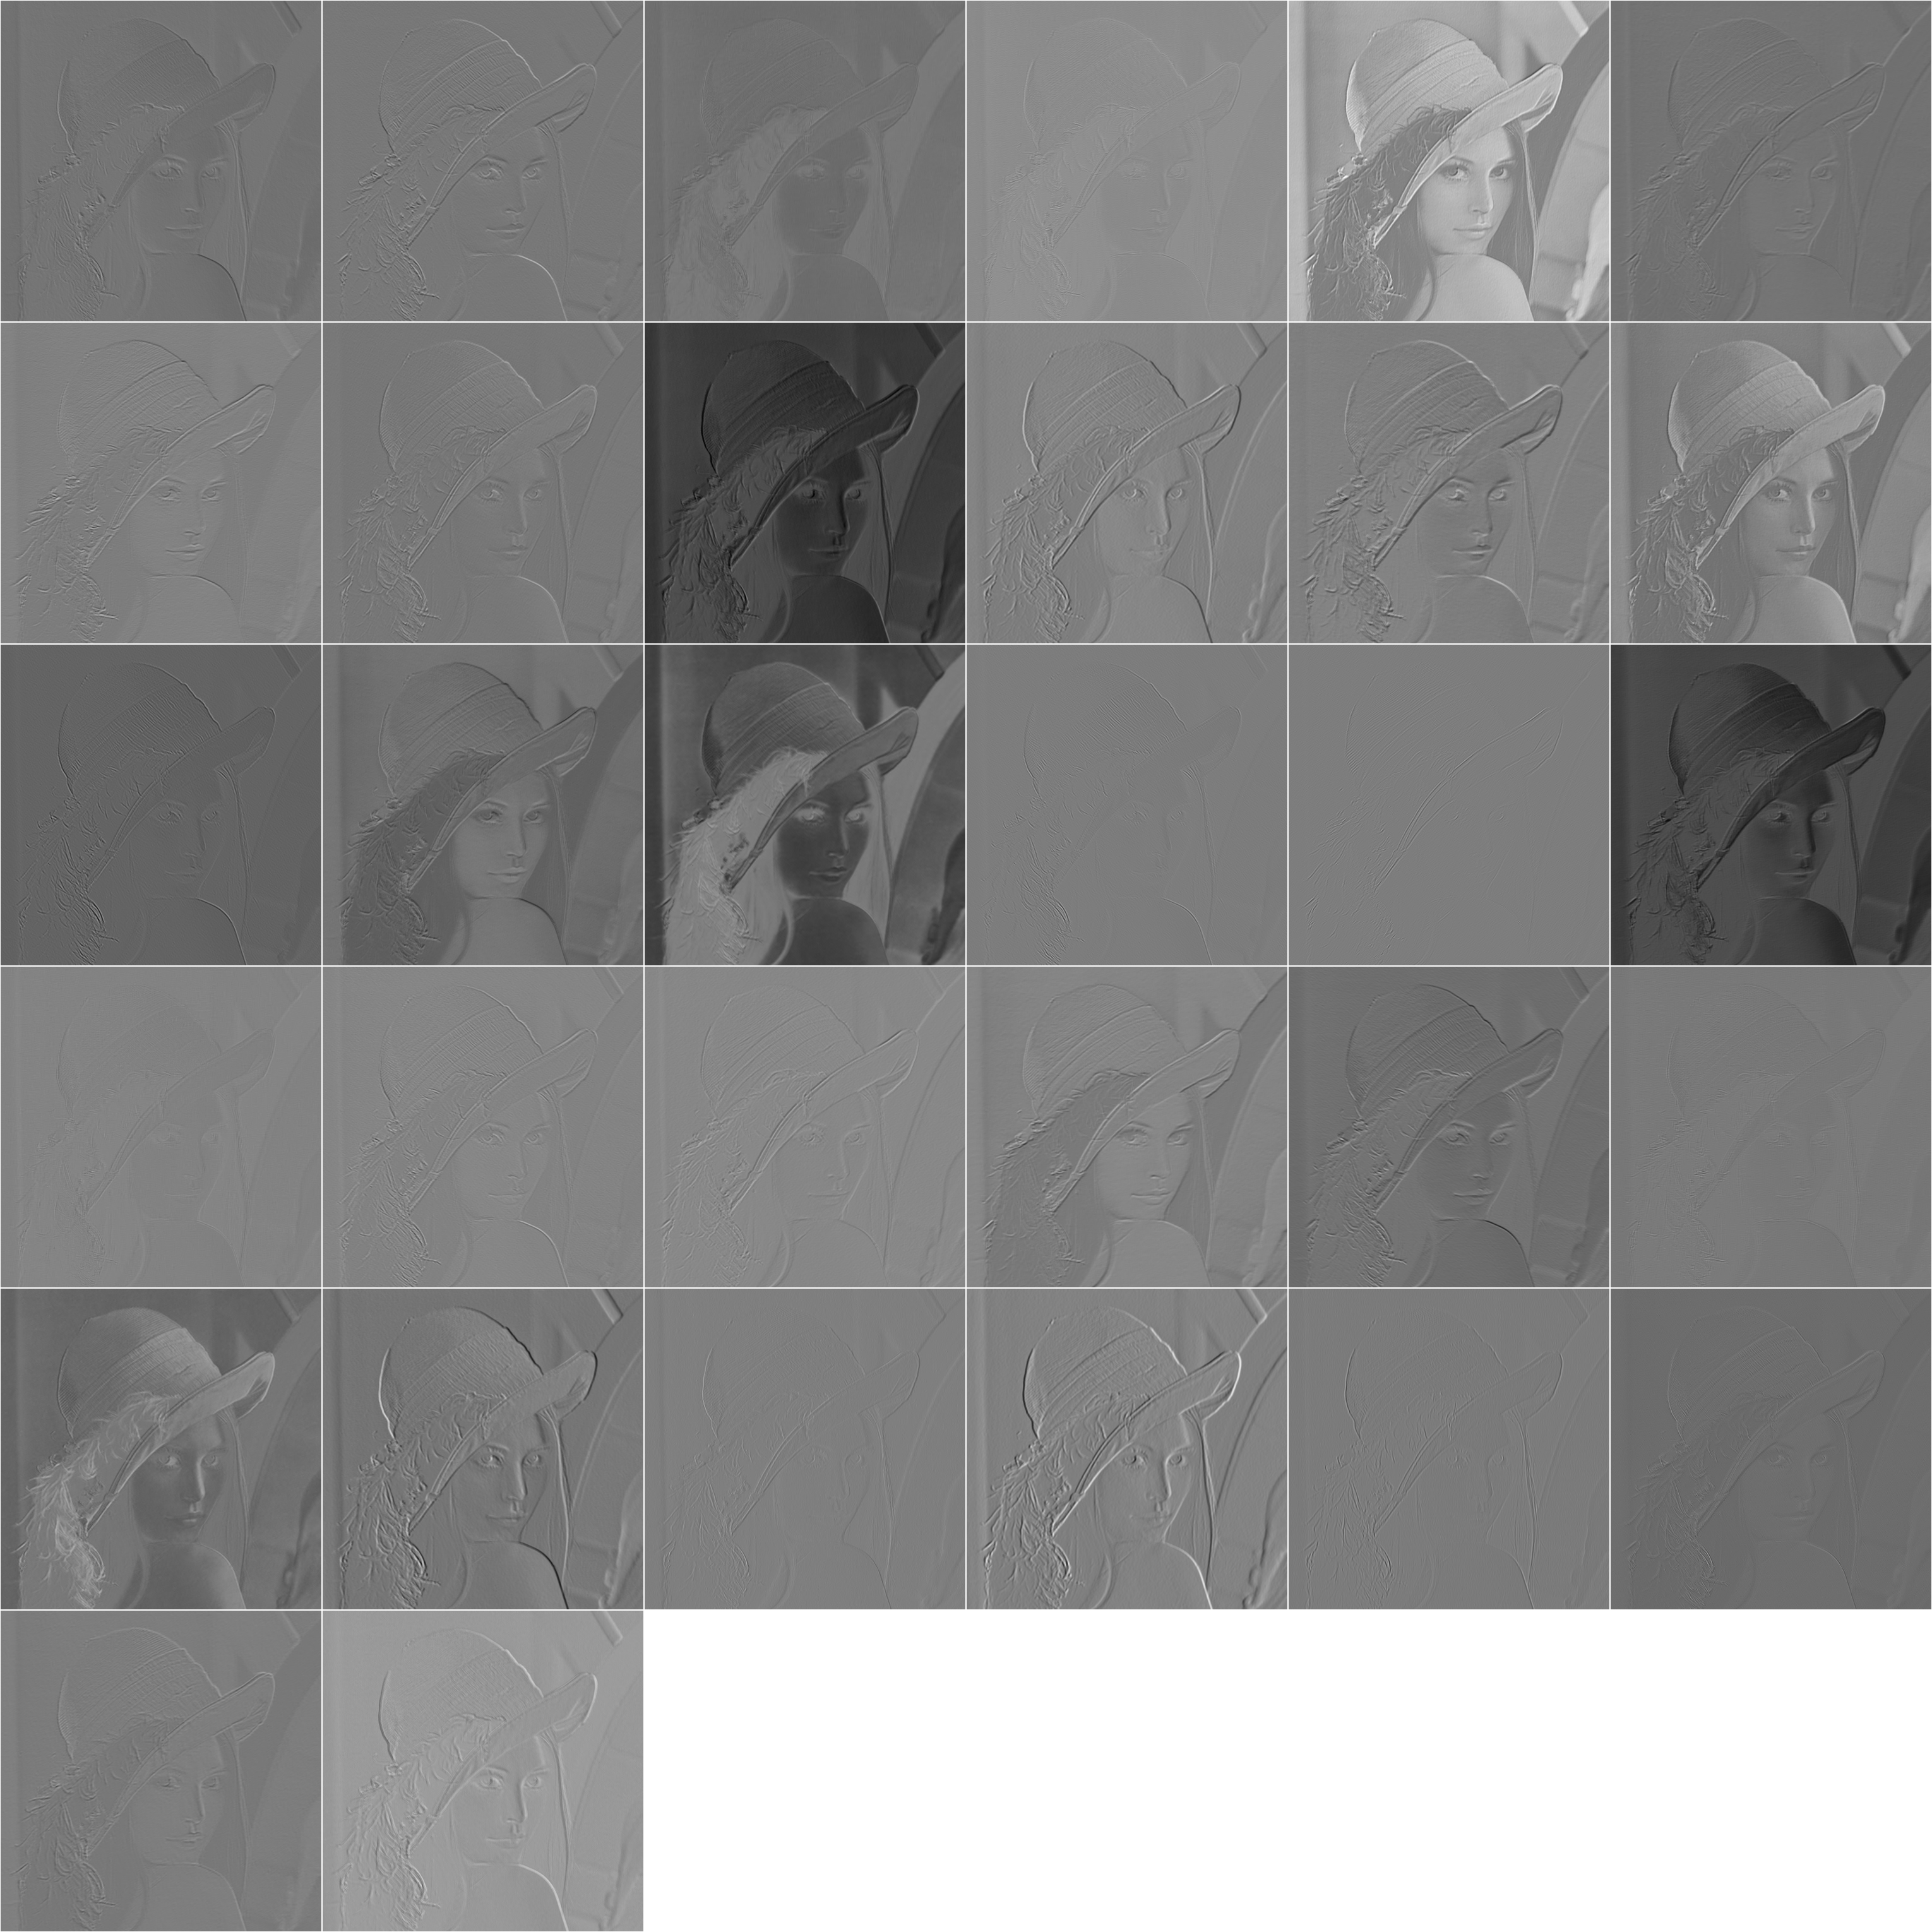

In [20]:
itorch.image(model:get(1):forward(img:cuda()))

### Building complex layers

In [21]:
InceptionLike = function(nInput, n1x1, n3x3r, n3x3, n5x5r, n5x5)

   
    local Module_1x1 = nn.Sequential()
    Module_1x1:add(cudnn.SpatialConvolution(nInput,n1x1,1,1)):add(cudnn.ReLU(true))
    
    local Module_3x3 = nn.Sequential()
    Module_3x3:add(cudnn.SpatialConvolution(nInput,n3x3r,1,1)):add(cudnn.ReLU(true))
    Module_3x3:add(cudnn.SpatialConvolution(n3x3r,n3x3,3,3,1,1,1,1)):add(cudnn.ReLU(true))
    
    local Module_5x5 = nn.Sequential()
    Module_5x5:add(cudnn.SpatialConvolution(nInput,n5x5r,1,1)):add(cudnn.ReLU(true))
    Module_5x5:add(cudnn.SpatialConvolution(n5x5r,n5x5,5,5,1,1,2,2)):add(cudnn.ReLU(true))

    local InceptionModule = nn.Concat(2)
    InceptionModule:add(Module_1x1)
    InceptionModule:add(Module_3x3)
    InceptionModule:add(Module_5x5)
  

    return InceptionModule
end


In [22]:
require 'nn'
require 'cunn'
require 'cudnn'

model = nn.Sequential()
model:add(cudnn.SpatialConvolution(3,64,5,5,1,1,2,2)) 
model:add(cudnn.SpatialMaxPooling(3,3,2,2))      
model:add(nn.ReLU(true))
model:add(nn.SpatialBatchNormalization(64))    

model:add(InceptionLike(64, 32, 16, 32, 32, 32))  
model:add(nn.SpatialBatchNormalization(96))    

model:add(InceptionLike(96, 32, 16, 32, 16, 32))                       
model:add(nn.SpatialBatchNormalization(96))   
model:add(cudnn.SpatialMaxPooling(3,3,2,2))

model:add(InceptionLike(96, 32, 32, 128, 16, 96))                      
model:add(nn.SpatialBatchNormalization(256))    

model:add(cudnn.SpatialAveragePooling(7,7,1,1))
model:add(nn.View(256):setNumInputDims(3))  
model:add(nn.Dropout(0.5))                    
model:add(nn.Linear(256, #classes))       
model:add(nn.LogSoftMax())                    

model:cuda()
criterion = nn.ClassNLLCriterion():cuda()


w, dE_dw = model:getParameters()
print('Number of parameters:', w:nElement()) --over-specified model

Number of parameters:	150858	


In [24]:
optimState = {}
epochs = 25
trainLoss = torch.Tensor(epochs)
testLoss = torch.Tensor(epochs)
trainError = torch.Tensor(epochs)
testError = torch.Tensor(epochs)

--reset net weights
model:apply(function(l) l:reset() end)

for e = 1, epochs do
    trainData, trainLabels = shuffle(trainData, trainLabels) --shuffle training data
    trainLoss[e], trainError[e] = forwardNet(trainData, trainLabels, true)
    testLoss[e], testError[e], confusion = forwardNet(testData, testLabels, false)
    
    if e % 5 == 0 then
        print('Epoch ' .. e .. ':')
        print('Training error: ' .. trainError[e], 'Training Loss: ' .. trainLoss[e])
        print('Test error: ' .. testError[e], 'Test Loss: ' .. testLoss[e])
        print(confusion)
    end
end

plotError(trainError, testError, 'Classification Error')

Epoch 5:	
Training error: 0.22540064102564	Training Loss: 0.65023789833754	
Test error: 0.24889823717949	Test Loss: 0.71686285008223	
ConfusionMatrix:
[[     817       7      13      19       7       1      12       6      57      59]   81.864% 	[class: airplane]
 [      17     815       0       5       3       0      10       2      11     136]   81.582% 	[class: automobile]
 [      99       5     574      85      43      37     106      20       8      22]   57.457% 	[class: bird]
 [      23      11      36     663      32      57     112      23      10      30]   66.500% 	[class: cat]
 [      29       1      60      59     664      12     102      52      11      10]   66.400% 	[class: deer]
 [      12       2      26     265      28     531      73      41       3      16]   53.260% 	[class: dog]
 [      14       2      25      36      11       5     890       2       6       9]   89.000% 	[class: frog]
 [      25       1      22      72      37      25      19     772       1    

Epoch 10:	
Training error: 0.16332131410256	Training Loss: 0.46738296777774	
Test error: 0.21905048076923	Test Loss: 0.65043648924583	
ConfusionMatrix:
[[     886      16      10      10       9       4       9       9      31      14]   88.778% 	[class: airplane]
 [      26     922       2       4       2       4       7       1       9      22]   92.292% 	[class: automobile]
 [      94       4     651      23      62      62      70      19      10       4]   65.165% 	[class: bird]
 [      43       2      54     563      46     187      60      30       6       6]   56.469% 	[class: cat]
 [      29       3      45      28     773      32      51      35       4       0]   77.300% 	[class: deer]
 [      14       2      32      84      38     759      27      39       2       0]   76.128% 	[class: dog]
 [      10       6      31      34      23      31     855       6       2       2]   85.500% 	[class: frog]
 [      20       2      21      24      47      68       8     799       2   

Epoch 15:	
Training error: 0.12435897435897	Training Loss: 0.35399084889736	
Test error: 0.20402644230769	Test Loss: 0.63744791692648	
ConfusionMatrix:
[[     784      26      14      24      18       4      13      16      63      36]   78.557% 	[class: airplane]
 [      11     913       1       5       1       2       8       4      12      42]   91.391% 	[class: automobile]
 [      57       5     628      66      71      67      61      24      12       8]   62.863% 	[class: bird]
 [      12       9      25     681      38     130      56      28       8      10]   68.305% 	[class: cat]
 [       8       4      33      52     769      30      33      64       6       1]   76.900% 	[class: deer]
 [       7       5      25     121      35     738      27      37       1       1]   74.022% 	[class: dog]
 [       8       5      23      46      30      19     848      10       7       4]   84.800% 	[class: frog]
 [      11       3      14      31      34      53       5     835       2   

Epoch 20:	
Training error: 0.09833733974359	Training Loss: 0.27900665803598	
Test error: 0.20452724358974	Test Loss: 0.67972074258022	
ConfusionMatrix:
[[     813      15      40      22      12      12      10      18      37      19]   81.463% 	[class: airplane]
 [      19     898       3       6       3       4       7       6      13      40]   89.890% 	[class: automobile]
 [      42       0     692      36      76      61      56      25       8       3]   69.269% 	[class: bird]
 [      15       1      68     580      60     191      43      33       4       2]   58.175% 	[class: cat]
 [      11       0      41      19     823      36      25      39       6       0]   82.300% 	[class: deer]
 [       6       1      31      91      45     760      23      39       1       0]   76.229% 	[class: dog]
 [       5       0      35      34      49      27     835       7       6       2]   83.500% 	[class: frog]
 [       7       1      14      24      46      43       8     845       3   

Epoch 25:	
Training error: 0.079306891025641	Training Loss: 0.22234758856969	
Test error: 0.21043669871795	Test Loss: 0.76579873302044	
ConfusionMatrix:
[[     843      14      37      26       9       3       5       2      39      20]   84.469% 	[class: airplane]
 [      16     896       4       9       2       1       7       2      19      43]   89.690% 	[class: automobile]
 [      48       3     715      78      48      25      60       8       8       6]   71.572% 	[class: bird]
 [      15       1      43     767      38      55      50      12       5      11]   76.931% 	[class: cat]
 [      16       1      44      74     795      12      40      10       7       1]   79.500% 	[class: deer]
 [       9       3      37     260      47     582      30      19       4       6]   58.375% 	[class: dog]
 [      12       1      33      59      20       5     863       2       3       2]   86.300% 	[class: frog]
 [      30       4      24      89      76      36      11     711       2  